In [1]:
from google.colab import files
uploaded = files.upload()

Saving training.data.npz to training.data.npz


In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=18a07432e50eb8e4fffc9e07ad22caa88ac8a73f1ef10ad1ea6aae079a51f67c
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 184.6 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [3]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, merge, UpSampling2D, Cropping2D, ZeroPadding2D, Reshape, core, Convolution2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import preprocessing
from keras import optimizers
from keras import backend as K
from keras.optimizers import SGD
from keras.layers.merge import concatenate
from random import shuffle
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [5]:
data = np.load('training.data.npz')
#s12mat,s21mat,sNomat,s12pos,s21pos,sNopos,s12_target,s21_target,sNo_target = [data[i] for i in ['s12mat', 's21mat', 'sNomat', 's12pos', 's21pos', 'sNopos', 's12_target', 's21_target', 'sNo_target']]

xdata = data['x']
ytarget = data['target']
s = xdata.shape

xdata,ytarget = np.reshape(xdata, newshape=(s[0], s[1], s[2], 1)), np.reshape(ytarget, newshape=(s[0], s[1], s[2], 1))

xdata_train,ytarget_train = xdata[1000:], ytarget[1000:]
xdata_test, ytarget_test  = xdata[:1000], ytarget[:1000] 

xdata_test.shape

(1000, 48, 128, 1)

In [79]:
def relu_clipped(x):
    return K.relu(x, max_value=1)

inputs = Input((s[1],s[2],1))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = relu_clipped)(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'mean_squared_error')
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 48, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_358 (Conv2D)             (None, 48, 128, 64)  640         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_359 (Conv2D)             (None, 48, 128, 64)  36928       conv2d_358[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_61 (MaxPooling2D) (None, 24, 64, 64)   0           conv2d_359[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [80]:
model.fit(xdata_train, ytarget_train, batch_size=32,
          epochs=25, verbose=1,
          validation_data=(xdata_test, ytarget_test))

Train on 19000 samples, validate on 1000 samples
Epoch 1/25
19000/19000 [==============================] - 132s 7ms/step - loss: 0.1230 - val_loss: 0.1142
Epoch 2/25
19000/19000 [==============================] - 126s 7ms/step - loss: 0.0898 - val_loss: 0.0928
Epoch 3/25
19000/19000 [==============================] - 127s 7ms/step - loss: 0.0826 - val_loss: 0.0802
Epoch 4/25
19000/19000 [==============================] - 127s 7ms/step - loss: 0.0735 - val_loss: 0.0714
Epoch 5/25
19000/19000 [==============================] - 127s 7ms/step - loss: 0.0644 - val_loss: 0.0661
Epoch 6/25
19000/19000 [==============================] - 127s 7ms/step - loss: 0.0562 - val_loss: 0.0577
Epoch 7/25
19000/19000 [==============================] - 127s 7ms/step - loss: 0.0509 - val_loss: 0.0516
Epoch 8/25
19000/19000 [==============================] - 127s 7ms/step - loss: 0.0471 - val_loss: 0.0497
Epoch 9/25
14400/19000 [=====================>........] - ETA: 30s - loss: 0.0449

KeyboardInterrupt: ignored

In [0]:
p = model.predict(xdata_test[20:400])

In [82]:

set([i.sum() for i in p])

{137.71155,
 175.48117,
 180.6782,
 198.16939,
 205.40793,
 211.76788,
 213.75491,
 225.3548,
 232.0639,
 269.16092,
 272.402,
 321.89258,
 330.52332,
 355.69327,
 360.15576,
 371.84717,
 403.283,
 404.50348,
 409.66568,
 424.14737,
 434.67493,
 442.73764,
 445.58923,
 447.3611,
 453.35178,
 457.30627,
 460.5889,
 476.09564,
 484.90283,
 485.45834,
 492.3213,
 518.179,
 519.9855,
 520.7136,
 526.42035,
 534.3699,
 536.4918,
 538.3783,
 547.7739,
 554.37854,
 563.28577,
 563.3056,
 568.52594,
 571.6704,
 576.9984,
 583.3704,
 614.51373,
 637.30347,
 637.6061,
 648.3725,
 648.4353,
 674.65875,
 679.9979,
 680.44226,
 681.2568,
 687.9461,
 688.2596,
 701.1365,
 703.15265,
 704.0698,
 707.44025,
 711.6901,
 715.22565,
 715.83264,
 725.0349,
 745.697,
 752.15466,
 757.9015,
 759.10156,
 769.3131,
 780.988,
 788.56995,
 793.87524,
 800.69226,
 827.64954,
 841.2856,
 842.59296,
 843.1949,
 849.30786,
 853.39044,
 854.1957,
 858.71265,
 865.9702,
 868.1845,
 868.2836,
 885.21564,
 896.9002,
 9

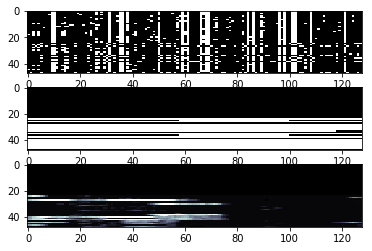

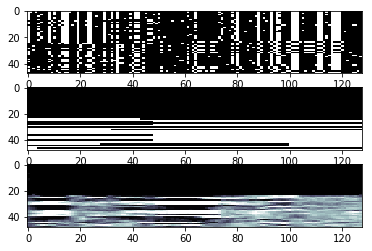

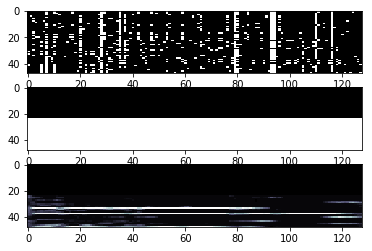

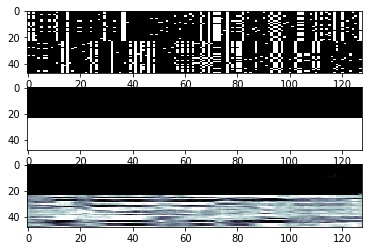

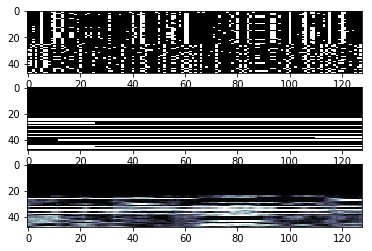

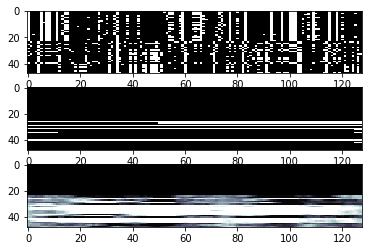

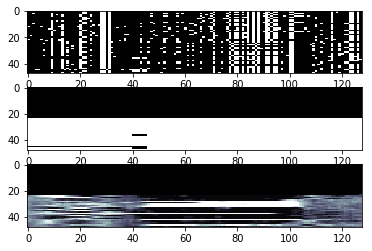

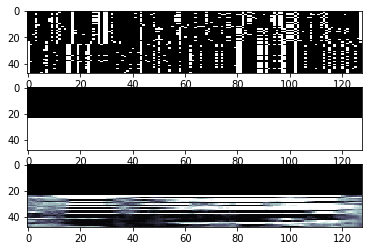

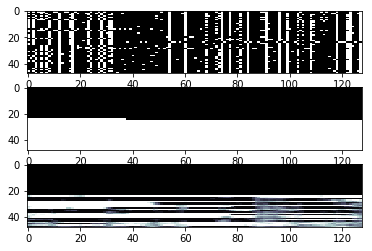

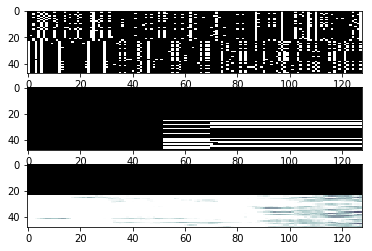

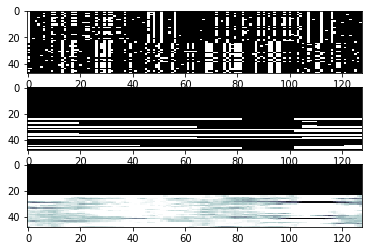

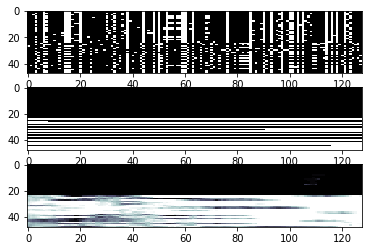

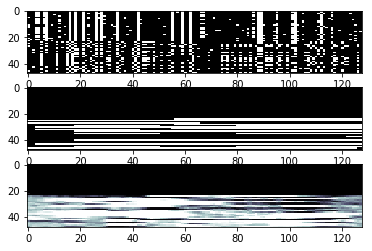

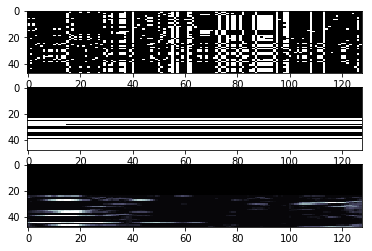

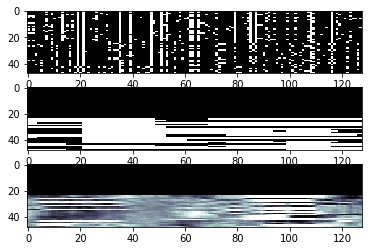

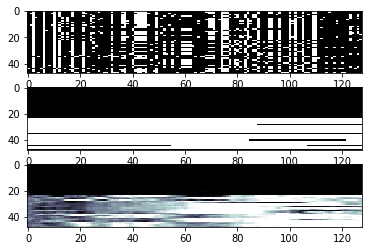

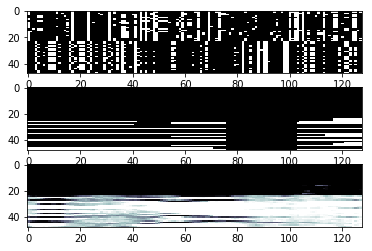

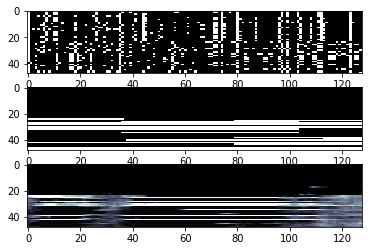

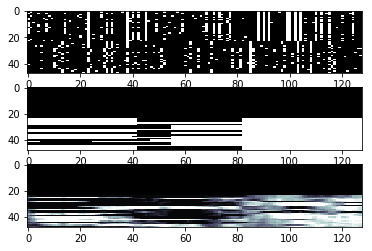

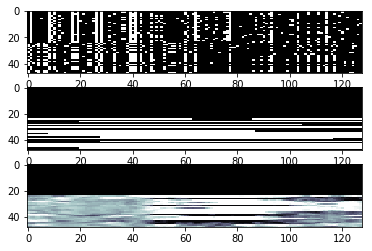

In [83]:
for i in range(20):
  plt.subplot(3,1,1)
  plt.imshow(np.reshape(xdata_test[i], (48, 128)), aspect=.5, cmap='bone')

  plt.subplot(3,1,2)
  plt.imshow(np.reshape(ytarget_test[i], (48, 128)), aspect=.5, cmap='bone')

  plt.subplot(3,1,3)
  plt.imshow(np.reshape(p[i],  (48, 128)), aspect=.5, cmap='bone')
  plt.show()